# 第5回講義 演習

## 目次

課題. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習
    1. MNISTデータセットの読み込み
    2. 畳み込みとプーリング in tensorflow
        - 2.1. 畳み込み: tf.nn.conv2d
        - 2.2. プーリング: tf.nn.max_pool, tf.nn.avg_pool, etc.
    2. 畳み込みとプーリング in tensorflow
        - 3.1. 畳み込み層
        - 3.2. プーリング層
        - 3.3.平滑化層（4次元->2次元）
        - 3.4. 全結合層
    4. 計算グラフ構築 & パラメータの更新設定
    5. 学習

## 課題. 畳み込みニューラルネットワーク(Convolutional Neural Networks)の実装と学習

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42

In [4]:
from matplotlib import pyplot as plt

## 1. MNISTデータセットの読み込み

畳み込みニューラルネットワーク(CNN)ではMNISTを4次元テンソルとして扱います。MNISTは縦と横のサイズが28×28で、チャネル数は1となるので、画像サイズは(バッチサイズ, 28,28, 1)となります。

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, t_train), (x_valid, t_valid) = mnist.load_data()

x_train = (x_train.reshape(-1, 28, 28, 1) / 255).astype(np.float32)
x_valid = (x_valid.reshape(-1, 28, 28, 1) / 255).astype(np.float32)

t_train = np.eye(10)[t_train].astype(np.float32)
t_valid = np.eye(10)[t_valid].astype(np.float32)

 9953280/11490434 [========================>.....] - ETA: 0s

## 2. 畳み込みとプーリング in tensorflow

### 2.1. 畳み込み: tf.nn.conv2d [\[link\]](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- 入力または隠れ層$X_{i, j}^{k}$
    - 次元数4$(n,i,j,k)$
        - $n$：バッチサイズ
        - $i$：入力の行数
        - $j$：入力の列数
        - $k$：入力のチャネル数
- 畳み込みのフィルタ（重み）$W_{i,j}^{k,l}$
    - 次元数4$(i,j,k,l)$
        - $i$: フィルタの行数
        - $j$: フィルタの列数
        - $k$: 入力のチャネル数
        - $l$: 出力のチャネル数(フィルタ数)
    - ストライド：フィルタを適用する位置の間隔
    - ゼロパディング：入力の周りに値0の縁を加えます
        - 入力のサイズを保つ為、フィルタの縦or横の次元が$F$のときパディング数を$(F-1)/2$とします。
- フィルタ後のサイズは、入力の縦or横の次元数$N$、フィルタの縦or横の次元数$F$、ストライドの縦or横の量$S$で決まります。
    - $(N-F)/S+1$

### 畳み込みの適用例

In [6]:
tf.reset_default_graph()

# 入力 (4次元)
x = tf.placeholder(tf.float32)

# サンプル画像
sample_image = np.array([[1, 1, 1, 0, 0],
                         [0, 1, 1, 1, 0],
                         [0, 0, 1, 1, 1],
                         [0, 0, 1, 1, 0],
                         [0, 1, 1, 0, 0]]
                       ).astype('float32').reshape(1, 5, 5, 1)  # バッチサイズ x 高さ x 幅 x チャンネル数

# フィルタ
W = np.array([[1, 0, 1],
              [0, 1, 0],
              [1, 0, 1]]).astype('float32').reshape(3, 3, 1, 1) # 高さ x 幅 x 入力チャンネル数　x 出力チャンネル数

In [7]:
sample_image.shape

(1, 5, 5, 1)

In [8]:
sample_image

array([[[[1.],
         [1.],
         [1.],
         [0.],
         [0.]],

        [[0.],
         [1.],
         [1.],
         [1.],
         [0.]],

        [[0.],
         [0.],
         [1.],
         [1.],
         [1.]],

        [[0.],
         [0.],
         [1.],
         [1.],
         [0.]],

        [[0.],
         [1.],
         [1.],
         [0.],
         [0.]]]], dtype=float32)

In [9]:
print(sample_image)

[[[[1.]
   [1.]
   [1.]
   [0.]
   [0.]]

  [[0.]
   [1.]
   [1.]
   [1.]
   [0.]]

  [[0.]
   [0.]
   [1.]
   [1.]
   [1.]]

  [[0.]
   [0.]
   [1.]
   [1.]
   [0.]]

  [[0.]
   [1.]
   [1.]
   [0.]
   [0.]]]]


In [10]:
print(W)

[[[[1.]]

  [[0.]]

  [[1.]]]


 [[[0.]]

  [[1.]]

  [[0.]]]


 [[[1.]]

  [[0.]]

  [[1.]]]]


#### 畳み込み1

- ストライド: (1, 1)
- パディング: なし ('VALID')
- 出力のサイズ: (5-3)/1+1=3

In [11]:
convoluted_image = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')  # strides: [1, 高さ, 幅, 1]
# 'VALID' means no zero padding

with tf.Session() as sess:
    print(sess.run(convoluted_image, feed_dict={x: sample_image}).reshape(3, 3))

[[4. 3. 4.]
 [2. 4. 3.]
 [2. 3. 4.]]


#### 畳み込み2

- ストライド: (2, 2)
- パディング: なし
- 出力のサイズ: (5-3)/2+1=2

In [12]:
convoluted_image = tf.nn.conv2d(x, W, strides=[1,2,2,1], padding='VALID')

with tf.Session() as sess:
    print(sess.run(convoluted_image, feed_dict={x: sample_image}).reshape(2, 2))

[[4. 4.]
 [2. 4.]]


#### 畳み込み3
- ストライド: (1, 1)
- パディング: (1, 1) 出力サイズが入力と同じになるように
- 出力のサイズ: (5-3+2)/1+1=5

In [13]:
convoluted_image = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
# 'SAME' means we do zero padding

with tf.Session() as sess:
    print(sess.run(convoluted_image, feed_dict={x: sample_image}).reshape(5, 5))

[[2. 2. 3. 1. 1.]
 [1. 4. 3. 4. 1.]
 [1. 2. 4. 3. 3.]
 [1. 2. 3. 4. 1.]
 [0. 2. 2. 1. 1.]]


### 畳み込みの演習

In [14]:
tf.reset_default_graph()

# 入力 (4次元)
x = tf.placeholder(tf.float32)

# サンプル画像
sample_image = np.array([[1, 1, 1, 0, 0, 1, 0],
                         [0, 1, 0, 1, 0, 1, 1],
                         [1, 0, 1, 1, 1, 0, 1],
                         [0, 0, 1, 1, 0, 1, 1],
                         [1, 1, 1, 1, 0, 0, 1],
                         [0, 1, 1, 1, 1, 1, 1],
                         [0, 1, 1, 0, 0, 1, 0]]
                       ).astype('float32').reshape(1, 7, 7, 1)

# フィルタ
W = np.array([[1, 0, 1],
              [0, 1, 0],
              [1, 0, 1]]).astype('float32').reshape(3, 3, 1, 1)

#### 畳み込み1

- ストライド: (1, 1)
- パディング: なし ('VALID')

In [15]:
convoluted_image = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')#WRITE ME

with tf.Session() as sess:
    print(sess.run(convoluted_image, feed_dict={x: sample_image}).reshape(5,5))

[[5. 2. 4. 2. 3.]
 [1. 4. 2. 5. 2.]
 [4. 4. 4. 2. 4.]
 [3. 4. 4. 4. 3.]
 [4. 4. 3. 3. 2.]]


#### 畳み込み2

- ストライド: (2, 2)
- パディング: なし

In [16]:
convoluted_image = tf.nn.conv2d(x, W, strides=[1,2,2,1], padding='VALID')#WRITE ME

with tf.Session() as sess:
    print(sess.run(convoluted_image, feed_dict={x: sample_image}).reshape(3,3))

[[5. 4. 3.]
 [4. 4. 4.]
 [4. 3. 2.]]


#### 畳み込み3

- ストライド: (1, 1)
- パディング: (1, 1)

In [17]:
convoluted_image = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')#WRITE ME

with tf.Session() as sess:
    print(sess.run(convoluted_image, feed_dict={x: sample_image}).reshape(7,7))

[[2. 1. 3. 0. 2. 2. 1.]
 [1. 5. 2. 4. 2. 3. 2.]
 [2. 1. 4. 2. 5. 2. 3.]
 [1. 4. 4. 4. 2. 4. 1.]
 [2. 3. 4. 4. 4. 3. 3.]
 [2. 4. 4. 3. 3. 2. 2.]
 [1. 2. 3. 2. 2. 3. 1.]]


### 2.2. プーリング: tf.nn.max_pool \[[link\]](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool), tf.nn.avg_pool \[[link\]](https://www.tensorflow.org/api_docs/python/tf/nn/avg_pool), etc.

- プーリングには次の種類があります。
    - Max pooling
    - Sum pooling
    - Mean pooling
    - その他Lpプーリングなど
- 畳み込みと同様、ストライドやパディングも考えることがあります。
- プーリング後のサイズは、入力の縦or横の次元数$N$、ウィンドウの縦or横の次元数$W$、ストライドの縦or横の量$S$で決まります。
    - $(N-W+1)/S$

### プーリングの適用例 

In [18]:
tf.reset_default_graph()

# 入力
x = tf.placeholder(tf.float32)

sample_image = np.array([[77, 80, 82, 78, 70],
                         [83, 78, 80, 83, 82],
                         [87, 82, 81, 80, 74],
                         [87, 87, 85, 77, 66],
                         [84, 79, 77, 78, 76]]
                        ).astype("float32").reshape(1, 5, 5, 1) 

#### プーリング1

- ウィンドウサイズ: (2, 2)
- ストライド: (2, 2)
- プーリング: max
- (5 -2+1) / 2 = 2

In [19]:
pooled_image = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

with tf.Session() as sess:
    print(sess.run(pooled_image, feed_dict={x: sample_image}).reshape(2, 2))

[[83. 83.]
 [87. 85.]]


#### プーリング2

- ウィンドウサイズ: (2, 2)
- ストライド: (1, 1)
- プーリング: max
- (5 -2+1) / 1 = 4

In [20]:
pooled_image = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,1,1,1], padding='VALID')

with tf.Session() as sess:
    print(sess.run(pooled_image, feed_dict={x: sample_image}).reshape(4, 4))

[[83. 82. 83. 83.]
 [87. 82. 83. 83.]
 [87. 87. 85. 80.]
 [87. 87. 85. 78.]]


#### プーリング3

- ウィンドウサイズ: (2, 2)
- ストライド: (2, 2)
- プーリング: mean
- (5 -2+1) / 2 = 2

In [21]:
pooled_image = tf.nn.avg_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

with tf.Session() as sess:
    print(sess.run(pooled_image, feed_dict={x: sample_image}).reshape(2, 2))

[[79.5  80.75]
 [85.75 80.75]]


### プーリングの演習

In [22]:
tf.reset_default_graph()

# 入力
x = tf.placeholder(tf.float32)

sample_image = np.array([[77, 80, 82, 78, 70, 76, 75],
                         [83, 78, 78, 73, 82, 82, 85],
                         [87, 82, 81, 80, 74, 88, 70],
                         [87, 87, 85, 77, 66, 83, 87],
                         [81, 83, 77, 79, 66, 83, 87],
                         [87, 87, 83, 70, 66, 83, 87],
                         [84, 79, 77, 78, 76, 75, 80]]
                        ).astype("float32").reshape(1, 7, 7, 1)

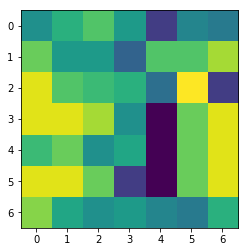

In [23]:
plt.imshow(sample_image.reshape(7,7))
plt.show()

#### プーリング1

- ウィンドウサイズ: (2, 2)
- ストライド: (2, 2)
- プーリング: max

In [24]:
pooled_image = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')#WRITE ME

with tf.Session() as sess:
    print(sess.run(pooled_image, feed_dict={x: sample_image}).reshape(3,3))

[[83. 82. 82.]
 [87. 85. 88.]
 [87. 83. 83.]]


#### プーリング2

- ウィンドウサイズ: (2, 2)
- ストライド: (1, 1)
- プーリング: max

In [25]:
pooled_image = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,1,1,1], padding='VALID')#WRITE ME

with tf.Session() as sess:
    print(sess.run(pooled_image, feed_dict={x: sample_image}).reshape(6,6))

[[83. 82. 82. 82. 82. 85.]
 [87. 82. 81. 82. 88. 88.]
 [87. 87. 85. 80. 88. 88.]
 [87. 87. 85. 79. 83. 87.]
 [87. 87. 83. 79. 83. 87.]
 [87. 87. 83. 78. 83. 87.]]


#### プーリング3

- ウィンドウサイズ: (2, 2)
- ストライド: (2, 2)
- プーリング: mean

In [26]:
pooled_image = tf.nn.avg_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')#WRITE ME

with tf.Session() as sess:
    print(sess.run(pooled_image, feed_dict={x: sample_image}).reshape(3,3))

[[79.5  77.75 77.5 ]
 [85.75 80.75 77.75]
 [84.5  77.25 74.5 ]]


## 3. 各層クラスの実装

### 3.1.  畳み込み層

活性化関数としてsigmoid関数やtanh関数のような対象な関数を使用する場合は、Xavierの初期化が使われることが多いです。以下の式で表されます。

$\displaystyle U(-\sqrt{\frac{6}{n_{\mathrm{input}} + n_{\mathrm{output}}}}, \sqrt{\frac{6}{n_{\mathrm{input}} + n_{\mathrm{output}}}})$

$U$: 一様分布、 $ n_{input}$: 入力層のユニット数、$n_{output}$: 出力層のユニット数

今回の場合、非対称なReLUを活性化関数として使うので、Heの初期化を使用しています。以下の式で表されます。

$\displaystyle U(-\sqrt{\frac{6}{n_{\mathrm{input}}}}, \sqrt{\frac{6}{n_{\mathrm{input}}}})$

$U$: 一様分布、 $ n_{input}$: 入力層のユニット数

In [38]:
# ninput: windowのn
class Conv:
    def __init__(self, filter_shape, function=lambda x: x, strides=[1,1,1,1], padding='VALID'):
        # Heの初期値
        # filter_shape: (縦の次元数)x(横の次元数)x(入力チャンネル数)x(出力チャンネル数)
        fan_in = np.prod(filter_shape[:3])# WRITE ME
        fan_out = np.prod(filter_shape[:2]) * filter_shape[3]# WRITE ME
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/fan_in),# WRITE ME,
                        high=np.sqrt(6/fan_in),# WRITE ME,
                        size=filter_shape
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros((filter_shape[3]), dtype='float32'), name='b') # バイアスはフィルタごとなので, 出力フィルタ数と同じ次元数
        self.function = function
        self.strides = strides
        self.padding = padding

    def __call__(self, x):
        u = tf.nn.conv2d(x, self.W, strides=self.strides, padding=self.padding) + self.b#WRITE ME
        return self.function(u)

### 3.2. プーリング層

In [28]:
class Pooling:
    def __init__(self, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
    
    def __call__(self, x):
        return tf.nn.max_pool(x, ksize=self.ksize, strides=self.strides, padding=self.padding)#WRITE ME (max pooling)

### 3.3. 平滑化層（4次元->2次元）

In [29]:
class Flatten:
    def __call__(self, x):
        return tf.reshape(x, (-1, np.prod(x.get_shape().as_list()[1:])))

### 3.4. 全結合層

In [30]:
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # He Initialization
        # in_dim: 入力の次元数、out_dim: 出力の次元数
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/in_dim),# WRITE ME,
                        high=np.sqrt(6/in_dim),# WRITE ME,
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def __call__(self, x):
        return self.function(tf.matmul(x, self.W) + self.b)#WRITE ME

## 4. 計算グラフ構築 & パラメータの更新設定

今Chapterから `tf` の `Optimizer` が使用可能になります。

使い方としては、最小化したい `cost` に対して以下のように学習率を指定することで
```
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
```
勾配降下法によるパラメータ更新のオペレーションを作成することができます。勾配降下法以外にもAdagrad、Adam等色々あるので、詳しくは公式のドキュメント[[link]](https://www.tensorflow.org/api_guides/python/train)を参照してください。

In [31]:
# tf.log(0)によるnanを防ぐ
def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

In [39]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 28, 28, 1])
t = tf.placeholder(tf.float32, [None, 10])
                                                                          
h = Conv((5, 5, 1, 20), tf.nn.relu)(x)
h = Pooling((1, 2, 2, 1))(h)
h = Conv((5, 5, 20, 50), tf.nn.relu)(h)
h = Pooling((1, 2, 2, 1))(h)
h = Flatten()(h)
y = Dense(4*4*50, 10, tf.nn.softmax)(h)

cost = - tf.reduce_mean(tf.reduce_sum(t * tf_log(y), axis=1))
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

## 5. 学習

In [40]:
n_epochs = 10
batch_size = 100
n_batches = x_train.shape[0]//batch_size

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        x_train, t_train = shuffle(x_train, t_train, random_state=random_state)
        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            sess.run(train, feed_dict={x: x_train[start:end], t: t_train[start:end]})
        y_pred, cost_valid = sess.run([y, cost], feed_dict={x: x_valid, t: t_valid})
        print('EPOCH: {}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
            epoch,
            cost_valid,
            accuracy_score(t_valid.argmax(axis=1), y_pred.argmax(axis=1))
        ))

EPOCH: 0, Valid Cost: 0.232, Valid Accuracy: 0.930
EPOCH: 1, Valid Cost: 0.156, Valid Accuracy: 0.957
EPOCH: 2, Valid Cost: 0.120, Valid Accuracy: 0.968
EPOCH: 3, Valid Cost: 0.101, Valid Accuracy: 0.971
EPOCH: 4, Valid Cost: 0.091, Valid Accuracy: 0.974
EPOCH: 5, Valid Cost: 0.082, Valid Accuracy: 0.975
EPOCH: 6, Valid Cost: 0.074, Valid Accuracy: 0.979
EPOCH: 7, Valid Cost: 0.067, Valid Accuracy: 0.981
EPOCH: 8, Valid Cost: 0.068, Valid Accuracy: 0.981
EPOCH: 9, Valid Cost: 0.070, Valid Accuracy: 0.979
